### TIME SERIES FORECASTING -- AUTO ARIMA

In [1]:
#Import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

# Import auto_arima 
from pmdarima.arima import auto_arima

#or
import pmdarima as pm

#auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model 
#that has the least AIC.

Let's do some data exploration a.k.a. EDA(Exploratory Data Analysis)

In [3]:
#Read the sales dataset
df = pd.read_csv("Champagne Sales.csv")

In [4]:
#Some general information over shape/dimensions of data
df.shape

(105, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Month            105 non-null    object
 1   Champagne sales  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [20]:
#Let's have a look at first five records
df.head()

,Month,Champagne sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


As we can see , our date is not exactly in pandas dateime format, so we will do parsing(we can do parsing and indexing at the time of making dataframe)

In [6]:
df =  pd.read_csv('Champagne Sales.csv',parse_dates=['Month'],index_col='Month')
df.head()

,Champagne sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


#Or we can do it afterwards like

#Convert the month column to datetime

df['Month']=pd.to_datetime(df['Month'])

#Set the index of the Month 

df.set_index('Month',inplace=True)

df.head()


In [8]:
# Now, let's run auto arima and print the summary
model = pm.auto_arima(df['Champagne sales'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1952.912, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2104.630, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1951.109, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2012.608, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1952.983, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1949.722, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1947.983, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1950.793, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1926.803, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1926.054, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1925.737, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1998.274, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1926.708, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1966.141, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]          

We can see that the best model is ARIMA(0,0,1)(0,0,0)[0] . The AIC is calculated as 1918.917

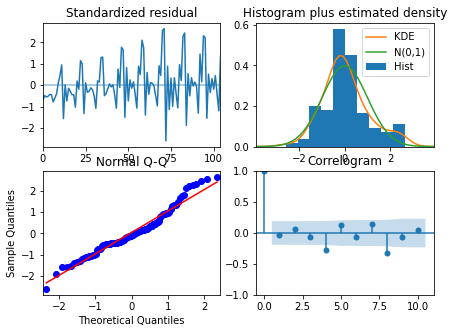

In [9]:
#Let’s review the residual plots using stepwise_fit.

model.plot_diagnostics(figsize=(7,5))
plt.show()

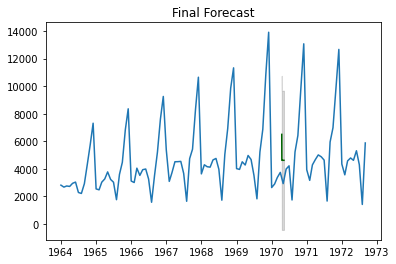

In [25]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['Champagne sales']), len(df['Champagne sales'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df['Champagne sales'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [32]:
#Let's evaluate our auto arima model and calculate rmse metric

def evaluate_auto_arima(df):
    
    train_len = int(len(df)*0.80)
    #print(train_len)
    train = df[0:train_len]

    test = df[train_len:]
    col=train.columns

    # AUTO ARIMA 
    #model = ARIMA(train,order=ord)
    model = pm.auto_arima(df['Champagne sales'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    #print(model.summary())
    # Fit model
    mf = model.fit(y=train,disp=0)
    
    #forecast
    fc  = pd.DataFrame(model.predict(n_periods=len(test),alpha=0.05),index=test.index)
    fc.columns=["Champagne sales"]
    #print(fc)
    #print(test)
    # RMSE
    rmse = np.mean((fc - test)**2)**.5  
    
    return rmse

In [34]:
rmse=evaluate_auto_arima(df)
print("Root Mean Square Value : ",rmse)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1952.912, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2104.630, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1951.109, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2012.608, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1952.983, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1949.722, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1947.983, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1950.793, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1926.803, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1926.054, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1925.737, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1998.274, Time=0.14 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1926.708, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1966.141, Time=0.13 sec
 ARIMA(2,0,3)(0,0,0)[0]          